In [1]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

##############################################
##############################################
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

data_path = os.path.join(os.getcwd(), 'Data')

In [2]:
def null_rate_data_cleaner(data, acceptable_null_percentage):
    """
    This function takes a data frame and an acceptable percentage of nulls
    and returns a subset of the data frame with columns that pass the null rate filter.   
    """
    data = data.copy()
    # Null percentage rate - we want variables with a small null rate
    null_rate_filter = (data.isna().sum() / len(data) < acceptable_null_percentage)
    
    columns_with_acceptable_null_rate = null_rate_filter[null_rate_filter].index
    
    filtered_data = data[columns_with_acceptable_null_rate]
    
    try:
        filtered_data = filtered_data.drop(columns=['transactiondate', 'propertycountylandusecode', 
                                                    'propertyzoningdesc'])
    except:
        pass
    # Fill the remaining nulls with zero
    # This is most likely NOT what you want to do in practice, but it will give a solution
    filtered_data = filtered_data.fillna(0)
    
    # Normalize the remaining numerical features
    # filtered_data = (filtered_data - filtered_data.mean()) / filtered_data.std()
    filtered_data = (filtered_data - filtered_data.min()) / (filtered_data.max() - filtered_data.min())
    
    return filtered_data

In [3]:
def display_scores(scores):
    print("==================================")
    print("Scores: {}".format(scores))
    print("==================================")
    print("Mean Score: {}".format(scores.mean()))
    print("==================================")
    print("Standard Deviation of Scores: {}".format(scores.std()))
    print("==================================")
    
    return None

In [4]:
zillow_data_dictionary = pd.read_excel(data_path+'/zillow_data_dictionary.xlsx')

for row in range(len(zillow_data_dictionary)):
    print(zillow_data_dictionary.iloc[row,0])
    print(zillow_data_dictionary.iloc[row,1])
    print('==================================================================')

'airconditioningtypeid'
 Type of cooling system present in the home (if any)
'architecturalstyletypeid'
 Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
'basementsqft'
 Finished living area below or partially below ground level
'bathroomcnt'
 Number of bathrooms in home including fractional bathrooms
'bedroomcnt'
 Number of bedrooms in home 
'buildingqualitytypeid'
 Overall assessment of condition of the building from best (lowest) to worst (highest)
'buildingclasstypeid'
The building framing type (steel frame, wood frame, concrete/brick) 
'calculatedbathnbr'
 Number of bathrooms in home including fractional bathroom
'decktypeid'
Type of deck (if any) present on parcel
'threequarterbathnbr'
 Number of 3/4 bathrooms in house (shower + sink + toilet)
'finishedfloor1squarefeet'
 Size of the finished living area on the first (entry) floor of the home
'calculatedfinishedsquarefeet'
 Calculated total finished living area of the home 
'finishedsquarefeet6'
Base unfin

In [5]:
properties = pd.read_csv(data_path+'/properties_2017.csv')
target = pd.read_csv(data_path+'/train_2017.csv')

properties.info()

/var/folders/5z/x2gtwzjj4qg4zyf332q1w47m0000gn/T/ipykernel_36533/680232650.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv(data_path+'/properties_2017.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   airconditioningtypeid         float64
 2   architecturalstyletypeid      float64
 3   basementsqft                  float64
 4   bathroomcnt                   float64
 5   bedroomcnt                    float64
 6   buildingclasstypeid           float64
 7   buildingqualitytypeid         float64
 8   calculatedbathnbr             float64
 9   decktypeid                    float64
 10  finishedfloor1squarefeet      float64
 11  calculatedfinishedsquarefeet  float64
 12  finishedsquarefeet12          float64
 13  finishedsquarefeet13          float64
 14  finishedsquarefeet15          float64
 15  finishedsquarefeet50          float64
 16  finishedsquarefeet6           float64
 17  fips                          float64
 18  fireplacecnt          

In [6]:
properties.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2016.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,5.0,NaN,NaN,NaN,...,1.0,NaN,660680.0,1434941.0,2016.0,774261.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,6.0,NaN,NaN,...,1.0,NaN,580059.0,1174475.0,2016.0,594416.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,1.0,NaN,196751.0,440101.0,2016.0,243350.0,5725.17,NaN,NaN,NaN


In [7]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcelid         77613 non-null  int64  
 1   logerror         77613 non-null  float64
 2   transactiondate  77613 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [8]:
properties.isna().sum()

parcelid                              0
airconditioningtypeid           2169855
architecturalstyletypeid        2979156
basementsqft                    2983590
bathroomcnt                        2957
bedroomcnt                         2945
buildingclasstypeid             2972486
buildingqualitytypeid           1043822
calculatedbathnbr                117156
decktypeid                      2967838
finishedfloor1squarefeet        2781459
calculatedfinishedsquarefeet      45097
finishedsquarefeet12             264431
finishedsquarefeet13            2977546
finishedsquarefeet15            2795032
finishedsquarefeet50            2781459
finishedsquarefeet6             2963735
fips                               2932
fireplacecnt                    2672093
fullbathcnt                      117156
garagecarcnt                    2094209
garagetotalsqft                 2094209
hashottuborspa                  2935155
heatingorsystemtypeid           1116053
latitude                           2932


In [9]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,2985217.0,1.332586e+07,7.909966e+06,1.071172e+07,1.164371e+07,1.254509e+07,1.409712e+07,1.696019e+08
airconditioningtypeid,815362.0,1.945723e+00,3.160507e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,6061.0,7.202607e+00,2.436290e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.700000e+01
basementsqft,1627.0,6.472207e+02,5.387871e+02,2.000000e+01,2.720000e+02,5.350000e+02,8.475000e+02,8.516000e+03
bathroomcnt,2982260.0,2.216196e+00,1.078250e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
bedroomcnt,2982272.0,3.093362e+00,1.271569e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.500000e+01
buildingclasstypeid,12731.0,3.734742e+00,5.003709e-01,1.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00
buildingqualitytypeid,1941395.0,6.280822e+00,1.729923e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,2868061.0,2.303826e+00,1.003243e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,3.200000e+01
decktypeid,17379.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [10]:
print('number of predictor variables is:', properties.shape[1]-1)
print('number of numeric variables: ', properties.select_dtypes(include=np.number).shape[1]-1)
print('number of categorical variables: ', properties.select_dtypes(include=object).shape[1])

number of predictor variables is: 57
number of numeric variables:  52
number of categorical variables:  5


In [11]:
merged_data = properties.merge(target, how='inner', on='parcelid')

Y = merged_data['logerror'].copy()
X = merged_data.drop('logerror', axis=1)

In [12]:
Y.describe()

count    77613.000000
mean         0.016755
std          0.170887
min         -4.655420
25%         -0.024325
50%          0.006670
75%          0.039295
max          5.262999
Name: logerror, dtype: float64

Text(0.5, 1.0, 'Log Error Value Frequency')

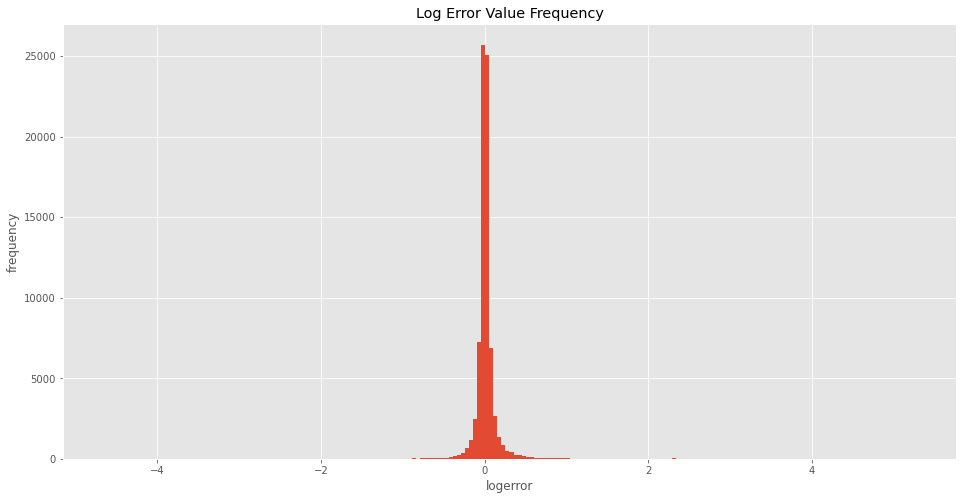

In [13]:
Y.hist(bins=200, figsize=(16,8))
plt.xlabel('logerror')
plt.ylabel('frequency')
plt.title('Log Error Value Frequency')

<AxesSubplot:ylabel='propertycountylandusecode'>

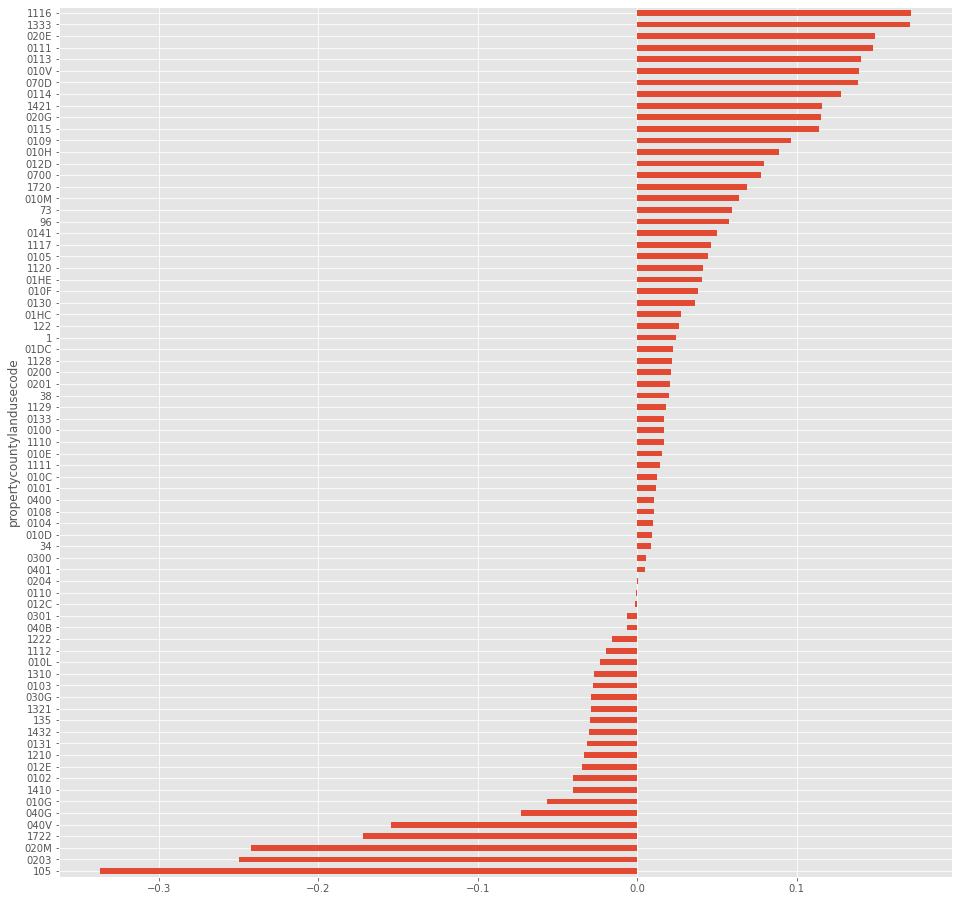

In [14]:
merged_data_grouped = merged_data.groupby('propertycountylandusecode')['logerror'].mean()

merged_data_grouped.sort_values(inplace=True)

merged_data_grouped.plot(kind='barh', figsize=(16,16))

In [15]:
corr_matrix = merged_data.corr()

corr_matrix.loc[:,'logerror'].sort_values(ascending=False)

logerror                        1.000000
basementsqft                    0.372067
buildingclasstypeid             0.315372
finishedsquarefeet6             0.072870
finishedsquarefeet12            0.045921
calculatedfinishedsquarefeet    0.040516
garagetotalsqft                 0.035015
bedroomcnt                      0.031638
calculatedbathnbr               0.029330
garagecarcnt                    0.029002
fullbathcnt                     0.027133
bathroomcnt                     0.025817
fireplacecnt                    0.023242
poolsizesum                     0.021174
longitude                       0.015876
threequarterbathnbr             0.015540
parcelid                        0.015407
roomcnt                         0.014567
lotsizesquarefeet               0.011012
airconditioningtypeid           0.009341
structuretaxvaluedollarcnt      0.008433
numberofstories                 0.008204
fips                            0.006413
rawcensustractandblock          0.006333
yearbuilt       

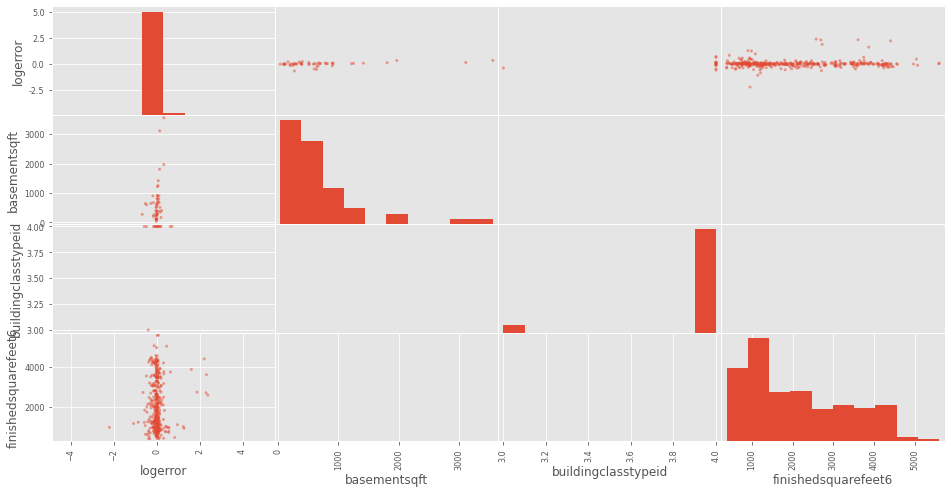

In [16]:
from pandas.plotting import scatter_matrix

interesting_variables = ['logerror', 'basementsqft', 'buildingclasstypeid', 'finishedsquarefeet6']
scatter_matrix(merged_data.loc[:, interesting_variables], figsize=(16,8));

In [17]:
merged_data.isna().sum()

parcelid                            0
airconditioningtypeid           52606
architecturalstyletypeid        77406
basementsqft                    77563
bathroomcnt                        34
bedroomcnt                         34
buildingclasstypeid             77598
buildingqualitytypeid           27804
calculatedbathnbr                 650
decktypeid                      76999
finishedfloor1squarefeet        71576
calculatedfinishedsquarefeet      235
finishedsquarefeet12             3690
finishedsquarefeet13            77571
finishedsquarefeet15            74586
finishedsquarefeet50            71576
finishedsquarefeet6             77227
fips                               34
fireplacecnt                    69324
fullbathcnt                       650
garagecarcnt                    52093
garagetotalsqft                 52093
hashottuborspa                  76074
heatingorsystemtypeid           28042
latitude                           34
longitude                          34
lotsizesquar

In [18]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=42)
Y_train, Y_test = train_test_split(Y, test_size=0.25, random_state=42)

In [21]:
X_train_cleaned = null_rate_data_cleaner(X_train, 0.8)
X_test_cleaned = null_rate_data_cleaner(X_test, 0.8)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

In [23]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_cleaned, Y_train)

LinearRegression()

In [24]:
Y_hat_train = lin_reg.predict(X_train_cleaned)
np.sqrt(mean_squared_error(Y_train, Y_hat_train))

0.16852587002950073

In [25]:
scores = cross_val_score(lin_reg, X_train_cleaned, Y_train, 
                                scoring="neg_mean_squared_error",
                                cv=5)

lin_reg_rmse_in_sample_estimates = np.sqrt(-scores)

display_scores(lin_reg_rmse_in_sample_estimates)

Scores: [0.15616977 0.17042558 0.17745503 0.17178871 0.16809471]
Mean Score: 0.1687867603973746
Standard Deviation of Scores: 0.0070214496657295955


In [26]:
tree_reg = DecisionTreeRegressor()

tree_reg.fit(X_train_cleaned, Y_train)

DecisionTreeRegressor()

In [27]:
Y_hat_train = tree_reg.predict(X_train_cleaned)
np.sqrt(mean_squared_error(Y_train, Y_hat_train))

0.011688693829132972

In [28]:
scores = cross_val_score(tree_reg, X_train_cleaned, Y_train, 
                                scoring="neg_mean_squared_error",
                                cv=5)

tree_rmse_in_sample_estimates = np.sqrt(-scores)

display_scores(tree_rmse_in_sample_estimates)

Scores: [0.24582987 0.25262914 0.24925371 0.25969717 0.25036322]
Mean Score: 0.2515546222212577
Standard Deviation of Scores: 0.004624763048482927


Trying Gridsearch

In [29]:
decision_tree_reg = DecisionTreeRegressor()

decision_tree_reg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [30]:
import warnings
warnings.filterwarnings("ignore")


decision_tree_param_grid = {"splitter":["best","random"],
                           "max_depth" : [7,9,11,12],
                           "min_samples_leaf":[3,4,5,6,7,8]}

In [31]:
grid_search = GridSearchCV(decision_tree_reg,
                          decision_tree_param_grid,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True, 
                          refit=True)

grid_search.fit(X_train_cleaned, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [7, 9, 11, 12],
                         'min_samples_leaf': [3, 4, 5, 6, 7, 8],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [32]:
np.sqrt(grid_search.best_score_*-1)

0.16854558392989333

In [33]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=7, min_samples_leaf=6, splitter='random')

In [34]:
final_model = grid_search.best_estimator_

Y_hat_test = final_model.predict(X_test_cleaned)

final_mse = mean_squared_error(Y_test, Y_hat_test)

final_rmse = np.sqrt(final_mse)

final_rmse

0.19647976062133388

In [35]:
# For comparison with Linear Regression

lin_Y_hat_test = lin_reg.predict(X_test_cleaned)

lin_final_mse = mean_squared_error(Y_test, lin_Y_hat_test)

lin_final_rmse = np.sqrt(lin_final_mse)

lin_final_rmse

0.2582149435077868

In [36]:
forest_reg = RandomForestRegressor()

forest_reg.fit(X_train_cleaned, Y_train)

scores = cross_val_score(forest_reg, X_train_cleaned, Y_train, 
                                scoring="neg_mean_squared_error",
                                cv=5)

forest_rmse_in_sample_estimates = np.sqrt(-scores)

display_scores(forest_rmse_in_sample_estimates)

Scores: [0.16263607 0.17348705 0.1797184  0.17481812 0.17286964]
Mean Score: 0.17270585446576148
Standard Deviation of Scores: 0.005579876977115934


In [37]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [38]:
forest_reg_param_grid = {"n_estimators":[3, 10, 20, 40],
                         'max_features': [2, 4, 6, 8]}

grid_search_forest = GridSearchCV(forest_reg,
                                  forest_reg_param_grid,
                                  cv=5,
                                  scoring='neg_mean_squared_error',
                                  return_train_score=True, 
                                  refit=True)

grid_search_forest.fit(X_train_cleaned, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 20, 40]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [39]:
grid_search_forest.best_params_

{'max_features': 2, 'n_estimators': 40}

In [40]:
forest_model = grid_search_forest.best_estimator_

Y_hat_test = forest_model.predict(X_test_cleaned)

forest_mse = mean_squared_error(Y_test, Y_hat_test)

forest_rmse = np.sqrt(forest_mse)

forest_rmse

0.1911569428309403

In [41]:
xgb_reg = xgboost.XGBRegressor()

X_train_cleaned_xgb = X_train_cleaned.rename(columns={'<1H OCEAN': 'less_than_1H Ocean'})
xgb_reg.fit(X_train_cleaned_xgb, Y_train)

scores = cross_val_score(xgb_reg, X_train_cleaned_xgb, Y_train, 
                                scoring="neg_mean_squared_error",
                                cv=10)

xgb_rmse_in_sample_estimates = np.sqrt(-scores)

display_scores(xgb_rmse_in_sample_estimates)

Scores: [0.15459892 0.17030884 0.17373009 0.17454985 0.16027007 0.19932517
 0.18009111 0.17241325 0.17129479 0.17309022]
Mean Score: 0.1729672305880318
Standard Deviation of Scores: 0.01121327933483117


In [42]:
xgb_reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [43]:
xgb_param_grid = {"learning_rate":[0.1, 0.2, 0.3, 0.4],
                  "gamma":[ 0.0, 0.1, 0.2],
                  "max_depth":[5, 6, 7]}

grid_search_xgb = GridSearchCV(xgb_reg,
                               xgb_param_grid,
                               cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True, 
                               refit=True)

In [44]:
grid_search_xgb.fit(X_train_cleaned, Y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0, gpu_id=-1,
                                    grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012,...
                                    max_cat_threshold=64, max_cat_to_onehot=4,
                                    max_delta_step=0, max_depth=6, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=0, ...),
             param_grid={'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': [5, 6, 7]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [45]:
grid_search_xgb.best_params_

{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5}

In [46]:
xgb_model = grid_search_xgb.best_estimator_

Y_hat_test = xgb_model.predict(X_test_cleaned)

xgb_mse = mean_squared_error(Y_test, Y_hat_test)

xgb_rmse = np.sqrt(xgb_mse)

xgb_rmse

0.2269995331505276

<b> Conclusion </b>

In this experiment, I first explored the data, looking at a histogram of the target variable, and a scatter matrix of highly correlated variables. However, as noted above, that scatter matrix was a bit flawed due to the selection of variables with large amounts of null values. As such, it might be better to first clean the columns by getting rid of any variables with high amounts of null values, and then further investingating from there. 

Next, I split the data into the test and train sets. After that, I used the linear and decision tree regressor to fit the training set. Following that, I used a grid search to find the best estimator to use in the decision tree regressor model. I also tried using the random forest and xgboost regressor, but found them to not be as optimal as the decision tree, possible due to the nature of the data. 

I would like to further investigate by first finding a different way to deal with some null values, such as mean or median fill, or to have a stricter criteria of elimination. I can also potentially look into getting rid of any outliers, which might be defined as being more than 2.5 standard deviations from the mean (since the distribution of logerror seems to follow a normal distribution). While more predictor variables might be eliminated, it might just be a better way to deal with them, as filling null values with 0 is not the best option at all times.

After that, I would like to explore further models, perhaps with the support vector regressor, though it might not be a better model for this problem. 